In [127]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
# Dynamic path setup
import sys
from pathlib import Path

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set
 
df = build_training_set(
    train_start="2025-01-01 00:00:00",
    train_end="2025-03-14 23:00:00",
    run_date="2025-03-15 00:00:00"
)


2025-05-28 08:08:55,783 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-28 08:08:55,787 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-28 08:08:55,788 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-28 08:08:55,841 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-28 08:08:56,225 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=

In [ ]:
from sklearn.ensemble import RandomForestRegressor

df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df['Timestamp'] = df['target_datetime']
# Feature engineering
df = df.dropna(subset=['target_datetime', 'Price'])

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01', tz = 'UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz = 'UTC')
test_start = pd.Timestamp('2025-03-15', tz = 'UTC')
test_end = pd.Timestamp('2025-03-21 23:59:59', tz = 'UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

X_train = train[['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]	
y_train = train['Price']
X_test = test[['weekday_sin', 'weekday_cos', 'hour_sin', 'hour_cos']]	
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.03885165439220991
MAE: 0.03885165439220991
RMSE: 0.05183017036495341


In [ ]:
from sklearn.ensemble import RandomForestRegressor

df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
df['Timestamp'] = df['target_datetime']
# Feature engineering
df = df.dropna(subset=['target_datetime', 'Price'])

# Stel de periodes in
train_start = pd.Timestamp('2025-01-01', tz = 'UTC')
train_end = pd.Timestamp('2025-03-14 23:59:59', tz = 'UTC')
test_start = pd.Timestamp('2025-03-15', tz = 'UTC')
test_end = pd.Timestamp('2025-03-21 23:59:59', tz = 'UTC')

# Filter op basis van Timestamp
train = df[(df['Timestamp'] >= train_start) & (df['Timestamp'] <= train_end)]
test = df[(df['Timestamp'] >= test_start) & (df['Timestamp'] <= test_end)]

# Features voor het model
features = [
    'Flow_NO','is_dst', 'hour_cos', 'hour_sin','month',
    'Load','is_non_working_day','shortwave_radiation', 'temperature_2m', 
    'yearday_sin', 'cloud_cover', 'Flow_GB',  'is_weekend', 'weekday_sin', 'weekday_cos'
]

X_train = train[features]
y_train = train['Price']
X_test = test[features]
y_test = test['Price']

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluatie
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, y_pred))

from sklearn.metrics import mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.03742950952380954
MAE: 0.03742950952380954
RMSE: 0.04875635346740416


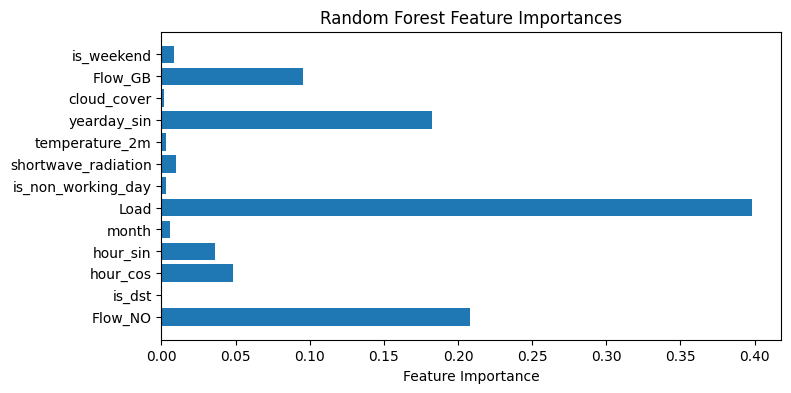

In [131]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

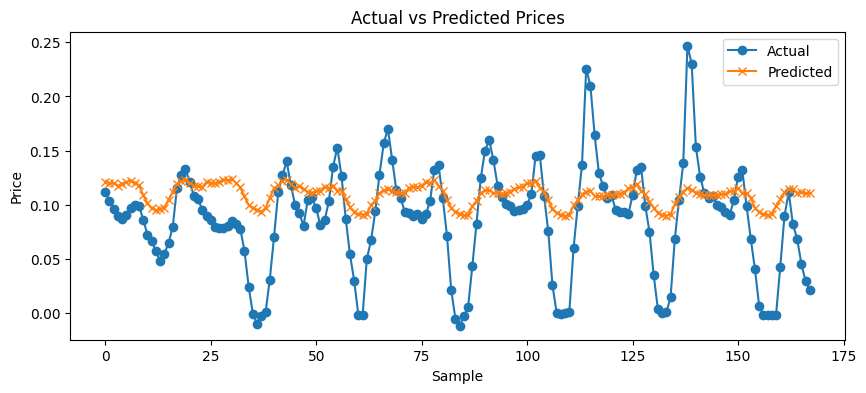

In [132]:
plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title("Actual vs Predicted Prices")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.show()

In [133]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Define feature columns and target
COMMON_FEATURES = [
    'is_dst', 'hour_cos', 'hour_sin', 'month', 'is_non_working_day',
    'shortwave_radiation', 'temperature_2m', 'cloud_cover', 'direct_normal_irradiance',
    'diffuse_radiation', 'is_weekend', 'yearday_cos', 'yearday_sin'
]
TRAIN_ONLY_FEATURES = ['Load', 'Flow_NO']  # Only used if known ex post

TRAIN_FEATURES = COMMON_FEATURES + TRAIN_ONLY_FEATURES
TEST_FEATURES = COMMON_FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start)  + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
else:
    print("❌ No runs completed successfully")

2025-05-28 08:09:59,400 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-28 08:09:59,401 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-28 08:09:59,402 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-28 08:09:59,456 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen


🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-28 08:09:59,764 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:09:59,785 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:09:59,786 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 1: ✅ 167 test rows, Run: 03-15


2025-05-28 08:10:01,351 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:01,372 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:01,375 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 2: ✅ 167 test rows, Run: 03-16


2025-05-28 08:10:02,832 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:02,853 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:02,855 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 3: ✅ 167 test rows, Run: 03-17


2025-05-28 08:10:04,198 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:04,247 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:04,249 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 4: ✅ 167 test rows, Run: 03-18


2025-05-28 08:10:05,582 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:05,604 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:05,605 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 5: ✅ 167 test rows, Run: 03-19


2025-05-28 08:10:07,054 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:07,083 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:07,084 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 6: ✅ 167 test rows, Run: 03-20


2025-05-28 08:10:08,990 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:09,011 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:09,012 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 7: ✅ 167 test rows, Run: 03-21


2025-05-28 08:10:10,244 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:10,280 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:10,281 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 8: ✅ 167 test rows, Run: 03-22


2025-05-28 08:10:11,565 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:11,588 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:11,590 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 9: ✅ 167 test rows, Run: 03-23


2025-05-28 08:10:12,872 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:12,896 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:12,897 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 10: ✅ 167 test rows, Run: 03-24


2025-05-28 08:10:14,132 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:14,156 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:14,157 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 11: ✅ 167 test rows, Run: 03-25


2025-05-28 08:10:15,491 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:15,508 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:15,509 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 12: ✅ 167 test rows, Run: 03-26


2025-05-28 08:10:16,723 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:16,742 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:16,743 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 13: ✅ 167 test rows, Run: 03-27


2025-05-28 08:10:17,969 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:17,986 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:17,987 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 14: ✅ 167 test rows, Run: 03-28


2025-05-28 08:10:19,340 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:19,357 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:19,358 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 15: ✅ 167 test rows, Run: 03-29


2025-05-28 08:10:20,846 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:20,865 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:20,866 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 16: ✅ 167 test rows, Run: 03-30


2025-05-28 08:10:22,265 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:22,285 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:22,286 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 17: ✅ 167 test rows, Run: 03-31


2025-05-28 08:10:23,624 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:23,648 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:23,649 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 18: ✅ 167 test rows, Run: 04-01


2025-05-28 08:10:25,094 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:25,124 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:25,126 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 19: ✅ 167 test rows, Run: 04-02


2025-05-28 08:10:26,632 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:26,654 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:26,655 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 20: ✅ 167 test rows, Run: 04-03


2025-05-28 08:10:28,111 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:28,132 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:28,133 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 21: ✅ 167 test rows, Run: 04-04


2025-05-28 08:10:29,564 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:29,584 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:29,586 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 22: ✅ 167 test rows, Run: 04-05


2025-05-28 08:10:31,075 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:31,092 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:31,092 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 23: ✅ 167 test rows, Run: 04-06


2025-05-28 08:10:32,438 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:32,456 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:32,457 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 24: ✅ 167 test rows, Run: 04-07


2025-05-28 08:10:33,784 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:33,804 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:33,805 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 25: ✅ 167 test rows, Run: 04-08


2025-05-28 08:10:35,332 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:35,358 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:35,359 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 26: ✅ 167 test rows, Run: 04-09


2025-05-28 08:10:36,925 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:36,946 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:36,947 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 27: ✅ 167 test rows, Run: 04-10


2025-05-28 08:10:38,539 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:38,558 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:38,559 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 28: ✅ 167 test rows, Run: 04-11


2025-05-28 08:10:40,295 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:40,315 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:40,316 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 29: ✅ 167 test rows, Run: 04-12


2025-05-28 08:10:41,910 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:10:41,927 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:10:41,928 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 30: ✅ 167 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                167  0.05
         2 2025-03-16                167  0.05
         3 2025-03-17                167  0.05
         4 2025-03-18                167  0.05
         5 2025-03-19                167  0.05
         6 2025-03-20                167  0.05
         7 2025-03-21                167  0.05
         8 2025-03-22                167  0.04
         9 2025-03-23                167  0.03
        10 2025-03-24                167  0.05
        11 2025-03-25                167  0.05
        12 2025-03-26                167  0.05
        13 2025-03-27                167  0.06
        14 2025-03-28                167  0.06
        15 2025-03-29                167  0.06
        16 2025-03-30                167  0.06
        17 2025-03-31                167  0.06
        18 2025-04-01                167  0.06
        19

In [134]:
import numpy as np

# Calculate RMSE per horizon
rmse_per_horizon = result_df.groupby('Horizon').apply(
    lambda g: np.sqrt(np.mean((g['Actual'] - g['Predicted'])**2))
)

# Print nicely
for h, rmse in rmse_per_horizon.items():
    print(f"Average RMSE for {int(h)+1} days ahead: {rmse:.4f}")

Average RMSE for 1 days ahead: 0.0297
Average RMSE for 2 days ahead: 0.0371
Average RMSE for 3 days ahead: 0.0351
Average RMSE for 4 days ahead: 0.0408
Average RMSE for 5 days ahead: 0.0438
Average RMSE for 6 days ahead: 0.0493
Average RMSE for 7 days ahead: 0.0564


C:\Users\shba\AppData\Local\Temp\ipykernel_1416\1407637168.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_horizon = result_df.groupby('Horizon').apply(


In [137]:
# fixed start day

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
# Dynamic path setup
import sys
from pathlib import Path

# Find project root dynamically
current_dir = Path.cwd()
while current_dir.name != "ENEXIS" and current_dir.parent != current_dir:
    current_dir = current_dir.parent
project_root = current_dir

# Add utils to path
utils_path = project_root / "src" / "utils"
sys.path.append(str(utils_path))
from build_training_set import build_training_set

# Define feature columns and target
COMMON_FEATURES = [
    'is_dst', 'hour_cos', 'hour_sin', 'month', 'is_non_working_day',
    'shortwave_radiation', 'temperature_2m', 'cloud_cover', 'direct_normal_irradiance',
    'diffuse_radiation', 'is_weekend', 'yearday_cos', 'yearday_sin'
]
TRAIN_ONLY_FEATURES = ['Load', 'Flow_NO']  # Only used if known ex post

TRAIN_FEATURES = COMMON_FEATURES + TRAIN_ONLY_FEATURES
TEST_FEATURES = COMMON_FEATURES
target = 'Price'

# Initial training window
base_start = "2025-01-01 00:00:00"
base_end = "2025-03-14 23:00:00"
base_run = "2025-03-15 00:00:00"

rmse_results = []

print("🔍 Testing Random Forest Model - RMSE per forecast day")
print("=" * 60)

for i in range(30):
    start = pd.Timestamp(base_start) # + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )

        if df is None or df.empty:
            print(f"Day {i+1}: ❌ No training data returned")
            continue

        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')

        # Zorg dat run_date ook in UTC is
        run_date_utc = run_date.tz_localize("UTC")

        # Split into training and testing sets
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]

        # Drop any missing data in training
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])

        if test_data.empty or train_data.empty:
            print(f"Day {i+1}: ❌ Not enough data for training or testing")
            continue

        # Train model
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]

        # Aanvullen met NaN-kolommen waar nodig
        for col in TRAIN_FEATURES:
            if col not in test_data.columns:
                test_data[col] = np.nan

        X_test = test_data[TRAIN_FEATURES]
        y_test = test_data[target]

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append({
            'iteration': i + 1,
            'run_date': run_date.strftime('%Y-%m-%d'),
            'valid_predictions': len(test_data),
            'rmse': rmse
        })

        print(f"Day {i+1}: ✅ {len(test_data)} test rows, Run: {run_date.strftime('%m-%d')}")

    except Exception as e:
        print(f"Day {i+1}: ❌ Error: {e}")

# Create results dataframe
if rmse_results:
    rmse_df = pd.DataFrame(rmse_results)

    print(f"\n📊 OVERALL RMSE - Random Forest Model")
    print("=" * 80)
    print(f"Successful runs: {len(rmse_df)}/30")

    print(rmse_df[['iteration', 'run_date', 'valid_predictions', 'rmse']].round(2).to_string(index=False))

    print(f"\n📈 SUMMARY STATISTICS")
    print("-" * 40)
    print(rmse_df['rmse'].describe().round(2))

    print(f"\n📊 AVERAGE OVERALL RMSE")
    print("-" * 40)
    print(f"Mean RMSE: {rmse_df['rmse'].mean():.4f}")
else:
    print("❌ No runs completed successfully")

2025-05-28 08:15:34,008 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-28 08:15:34,010 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-28 08:15:34,012 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-28 08:15:34,063 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen


🔍 Testing Random Forest Model - RMSE per forecast day


2025-05-28 08:15:34,420 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:34,437 - build_training_set - INFO - 📦 Eindtabel bevat: 1920 rijen, 31 kolommen
2025-05-28 08:15:34,438 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 1: ✅ 167 test rows, Run: 03-15


2025-05-28 08:15:35,861 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:35,903 - build_training_set - INFO - 📦 Eindtabel bevat: 1944 rijen, 31 kolommen
2025-05-28 08:15:35,905 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 2: ✅ 167 test rows, Run: 03-16


2025-05-28 08:15:37,540 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:37,557 - build_training_set - INFO - 📦 Eindtabel bevat: 1968 rijen, 31 kolommen
2025-05-28 08:15:37,558 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 3: ✅ 167 test rows, Run: 03-17


2025-05-28 08:15:38,808 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:38,827 - build_training_set - INFO - 📦 Eindtabel bevat: 1992 rijen, 31 kolommen
2025-05-28 08:15:38,828 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 4: ✅ 167 test rows, Run: 03-18


2025-05-28 08:15:40,070 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:40,090 - build_training_set - INFO - 📦 Eindtabel bevat: 2016 rijen, 31 kolommen
2025-05-28 08:15:40,091 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 5: ✅ 167 test rows, Run: 03-19


2025-05-28 08:15:41,321 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:41,342 - build_training_set - INFO - 📦 Eindtabel bevat: 2040 rijen, 31 kolommen
2025-05-28 08:15:41,343 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 6: ✅ 167 test rows, Run: 03-20


2025-05-28 08:15:42,877 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:42,897 - build_training_set - INFO - 📦 Eindtabel bevat: 2064 rijen, 31 kolommen
2025-05-28 08:15:42,899 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 7: ✅ 167 test rows, Run: 03-21


2025-05-28 08:15:44,180 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:44,200 - build_training_set - INFO - 📦 Eindtabel bevat: 2088 rijen, 31 kolommen
2025-05-28 08:15:44,201 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 8: ✅ 167 test rows, Run: 03-22


2025-05-28 08:15:45,514 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:45,533 - build_training_set - INFO - 📦 Eindtabel bevat: 2112 rijen, 31 kolommen
2025-05-28 08:15:45,534 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 9: ✅ 167 test rows, Run: 03-23


2025-05-28 08:15:46,902 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:46,969 - build_training_set - INFO - 📦 Eindtabel bevat: 2136 rijen, 31 kolommen
2025-05-28 08:15:46,972 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 10: ✅ 167 test rows, Run: 03-24


2025-05-28 08:15:48,490 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:48,511 - build_training_set - INFO - 📦 Eindtabel bevat: 2160 rijen, 31 kolommen
2025-05-28 08:15:48,512 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 11: ✅ 167 test rows, Run: 03-25


2025-05-28 08:15:49,846 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:49,866 - build_training_set - INFO - 📦 Eindtabel bevat: 2184 rijen, 31 kolommen
2025-05-28 08:15:49,867 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 12: ✅ 167 test rows, Run: 03-26


2025-05-28 08:15:51,222 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:51,240 - build_training_set - INFO - 📦 Eindtabel bevat: 2208 rijen, 31 kolommen
2025-05-28 08:15:51,241 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 13: ✅ 167 test rows, Run: 03-27


2025-05-28 08:15:52,655 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:52,708 - build_training_set - INFO - 📦 Eindtabel bevat: 2232 rijen, 31 kolommen
2025-05-28 08:15:52,709 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 14: ✅ 167 test rows, Run: 03-28


2025-05-28 08:15:54,253 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:54,276 - build_training_set - INFO - 📦 Eindtabel bevat: 2256 rijen, 31 kolommen
2025-05-28 08:15:54,278 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 15: ✅ 167 test rows, Run: 03-29


2025-05-28 08:15:55,740 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:55,765 - build_training_set - INFO - 📦 Eindtabel bevat: 2280 rijen, 31 kolommen
2025-05-28 08:15:55,767 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 16: ✅ 167 test rows, Run: 03-30


2025-05-28 08:15:57,209 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:57,232 - build_training_set - INFO - 📦 Eindtabel bevat: 2304 rijen, 31 kolommen
2025-05-28 08:15:57,233 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 17: ✅ 167 test rows, Run: 03-31


2025-05-28 08:15:58,906 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:15:58,928 - build_training_set - INFO - 📦 Eindtabel bevat: 2328 rijen, 31 kolommen
2025-05-28 08:15:58,930 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 18: ✅ 167 test rows, Run: 04-01


2025-05-28 08:16:00,446 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:00,464 - build_training_set - INFO - 📦 Eindtabel bevat: 2352 rijen, 31 kolommen
2025-05-28 08:16:00,466 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 19: ✅ 167 test rows, Run: 04-02


2025-05-28 08:16:02,008 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:02,086 - build_training_set - INFO - 📦 Eindtabel bevat: 2376 rijen, 31 kolommen
2025-05-28 08:16:02,091 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 20: ✅ 167 test rows, Run: 04-03


2025-05-28 08:16:03,702 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:03,729 - build_training_set - INFO - 📦 Eindtabel bevat: 2400 rijen, 31 kolommen
2025-05-28 08:16:03,730 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 21: ✅ 167 test rows, Run: 04-04


2025-05-28 08:16:05,421 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:05,443 - build_training_set - INFO - 📦 Eindtabel bevat: 2424 rijen, 31 kolommen
2025-05-28 08:16:05,444 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 22: ✅ 167 test rows, Run: 04-05


2025-05-28 08:16:06,969 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:06,991 - build_training_set - INFO - 📦 Eindtabel bevat: 2448 rijen, 31 kolommen
2025-05-28 08:16:06,993 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 23: ✅ 167 test rows, Run: 04-06


2025-05-28 08:16:08,646 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:08,668 - build_training_set - INFO - 📦 Eindtabel bevat: 2472 rijen, 31 kolommen
2025-05-28 08:16:08,669 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 24: ✅ 167 test rows, Run: 04-07


2025-05-28 08:16:10,318 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:10,344 - build_training_set - INFO - 📦 Eindtabel bevat: 2496 rijen, 31 kolommen
2025-05-28 08:16:10,345 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 25: ✅ 167 test rows, Run: 04-08


2025-05-28 08:16:11,913 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:11,943 - build_training_set - INFO - 📦 Eindtabel bevat: 2520 rijen, 31 kolommen
2025-05-28 08:16:11,952 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 26: ✅ 167 test rows, Run: 04-09


2025-05-28 08:16:13,662 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:13,686 - build_training_set - INFO - 📦 Eindtabel bevat: 2544 rijen, 31 kolommen
2025-05-28 08:16:13,688 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 27: ✅ 167 test rows, Run: 04-10


2025-05-28 08:16:15,328 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:15,377 - build_training_set - INFO - 📦 Eindtabel bevat: 2568 rijen, 31 kolommen
2025-05-28 08:16:15,378 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 28: ✅ 167 test rows, Run: 04-11


2025-05-28 08:16:17,220 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:17,244 - build_training_set - INFO - 📦 Eindtabel bevat: 2592 rijen, 31 kolommen
2025-05-28 08:16:17,245 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 29: ✅ 167 test rows, Run: 04-12


2025-05-28 08:16:18,915 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=True)
2025-05-28 08:16:18,935 - build_training_set - INFO - 📦 Eindtabel bevat: 2616 rijen, 31 kolommen
2025-05-28 08:16:18,935 - build_training_set - INFO - 🧾 Kolommen: ['Price', 'target_datetime', 'Load', 'shortwave_radiation', 'temperature_2m', 'direct_normal_irradiance', 'diffuse_radiation', 'Flow_NO', 'yearday_cos', 'Flow_GB', 'month', 'is_dst', 'yearday_sin', 'is_non_working_day', 'hour_cos', 'is_weekend', 'cloud_cover', 'weekday_sin', 'hour_sin', 'weekday

Day 30: ✅ 167 test rows, Run: 04-13

📊 OVERALL RMSE - Random Forest Model
Successful runs: 30/30
 iteration   run_date  valid_predictions  rmse
         1 2025-03-15                167  0.05
         2 2025-03-16                167  0.05
         3 2025-03-17                167  0.05
         4 2025-03-18                167  0.05
         5 2025-03-19                167  0.05
         6 2025-03-20                167  0.05
         7 2025-03-21                167  0.04
         8 2025-03-22                167  0.04
         9 2025-03-23                167  0.03
        10 2025-03-24                167  0.05
        11 2025-03-25                167  0.05
        12 2025-03-26                167  0.05
        13 2025-03-27                167  0.06
        14 2025-03-28                167  0.06
        15 2025-03-29                167  0.06
        16 2025-03-30                167  0.06
        17 2025-03-31                167  0.06
        18 2025-04-01                167  0.06
        19

2025-05-28 08:35:06,770 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-28 08:35:06,772 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-28 08:35:06,774 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-28 08:35:06,818 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-28 08:35:07,158 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=

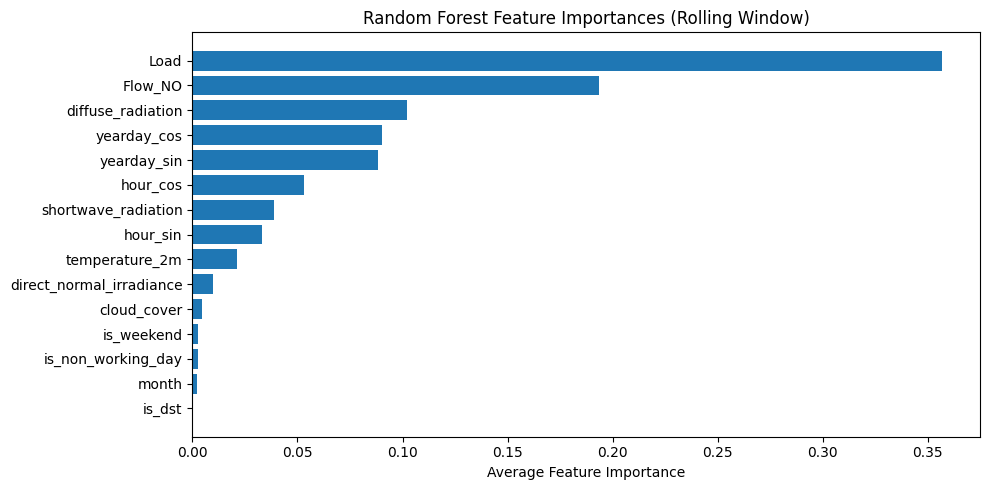

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect feature importances from each run
feature_importances = []
feature_names = TRAIN_FEATURES

for i in range(30):
    start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
    end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
    run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

    try:
        df = build_training_set(
            train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
            train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
            run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
        )
        if df is None or df.empty:
            continue
        df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
        df = df.sort_values('target_datetime').set_index('target_datetime')
        run_date_utc = run_date.tz_localize("UTC")
        train_data = df[df.index <= run_date_utc]
        test_data = df[df.index > run_date_utc]
        train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])
        if test_data.empty or train_data.empty:
            continue
        X_train = train_data[TRAIN_FEATURES]
        y_train = train_data[target]
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        feature_importances.append(model.feature_importances_)
    except Exception:
        continue

# Calculate mean importances
if feature_importances:
    importances_mean = np.mean(feature_importances, axis=0)
    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_mean
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
    plt.xlabel("Average Feature Importance")
    plt.title("Random Forest Feature Importances (Rolling Window)")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No feature importances collected.")

2025-05-28 08:48:38,275 - build_training_set - INFO - 🚀 Start build van trainingset
2025-05-28 08:48:38,278 - build_training_set - INFO - 🧠 Actuals van 2025-01-01 00:00:00+00:00 t/m 2025-03-14 23:00:00+00:00
2025-05-28 08:48:38,280 - build_training_set - INFO - 📅 Forecast van run_date 2025-03-15 00:00:00+00:00, target range: 2025-03-15 00:00:00+00:00 → 2025-03-21 23:00:00+00:00
2025-05-28 08:48:38,360 - build_training_set - INFO - ✅ Actuals geladen: 1752 rijen
2025-05-28 08:48:38,673 - build_training_set - INFO - ✅ Added actual prices to 168 forecast rows
c:\Users\shba\Documents\JADS project\ENEXIS\src\utils\build_training_set.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_actuals, df_preds], ignore_index=

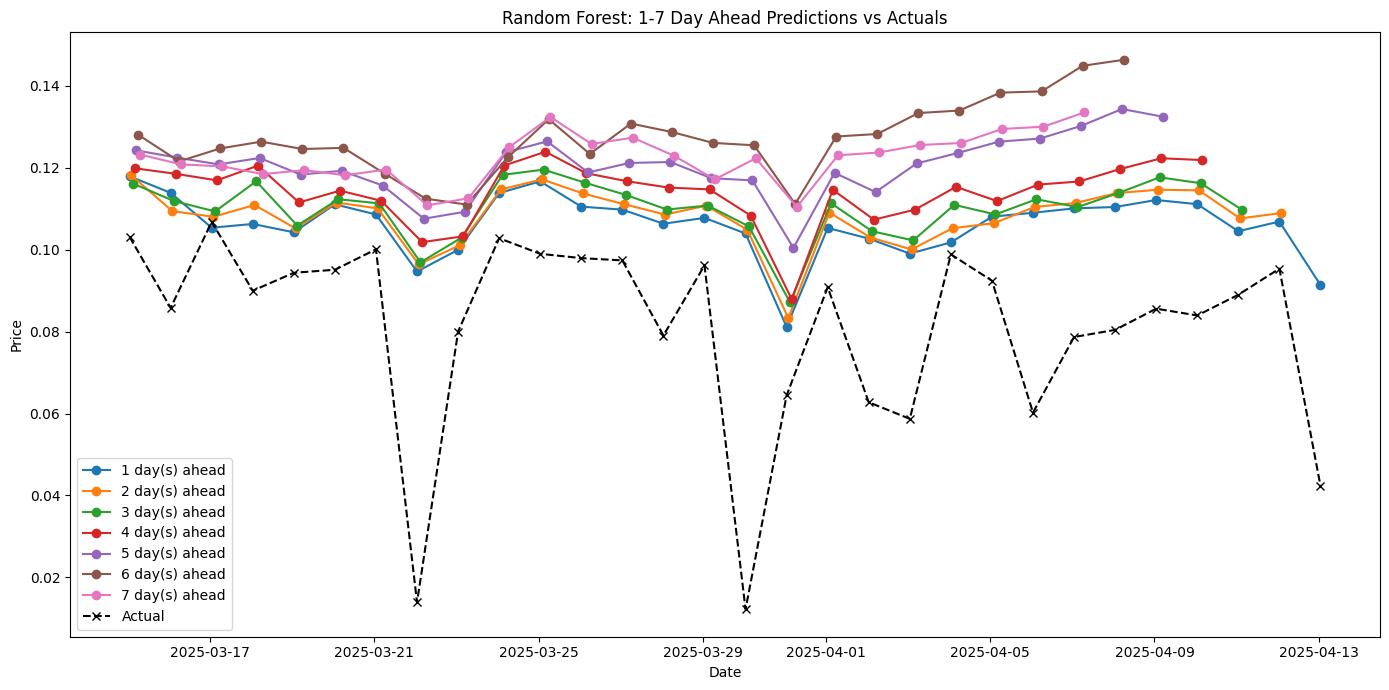

In [142]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Store predictions, actuals, and dates for each run
horizon_preds = {}  # key: horizon (days ahead), value: DataFrame with index=date, columns=['prediction']
actuals = {}

n_horizons = 7  # 7-day ahead forecasts

for horizon in range(1, n_horizons + 1):
    preds = []
    dates = []
    acts = []
    for i in range(30 - horizon + 1):  # ensure enough data for each horizon
        start = pd.Timestamp(base_start) + pd.Timedelta(days=i)
        end = pd.Timestamp(base_end) + pd.Timedelta(days=i)
        run_date = pd.Timestamp(base_run) + pd.Timedelta(days=i)

        try:
            df = build_training_set(
                train_start=start.strftime("%Y-%m-%d %H:%M:%S"),
                train_end=end.strftime("%Y-%m-%d %H:%M:%S"),
                run_date=run_date.strftime("%Y-%m-%d %H:%M:%S")
            )
            if df is None or df.empty:
                continue
            df['target_datetime'] = pd.to_datetime(df['target_datetime'], utc=True)
            df = df.sort_values('target_datetime').set_index('target_datetime')
            run_date_utc = run_date.tz_localize("UTC")
            train_data = df[df.index <= run_date_utc]
            test_data = df[df.index > run_date_utc]
            train_data = train_data.dropna(subset=TRAIN_FEATURES + [target])
            if test_data.empty or train_data.empty:
                continue
            X_train = train_data[TRAIN_FEATURES]
            y_train = train_data[target]
            X_test = test_data[TRAIN_FEATURES]
            y_test = test_data[target]
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            # For this horizon, pick the prediction for the (horizon-1)th row (if exists)
            if len(y_pred) >= horizon:
                pred_date = X_test.index[horizon-1]
                preds.append(y_pred[horizon-1])
                acts.append(y_test.iloc[horizon-1])
                dates.append(pred_date)
        except Exception:
            continue
    horizon_preds[horizon] = pd.Series(preds, index=dates)
    if horizon == 1:
        actuals = pd.Series(acts, index=dates)

# Plot: for each horizon, plot the predictions for each date
plt.figure(figsize=(14, 7))
for horizon in range(1, n_horizons + 1):
    s = horizon_preds[horizon].sort_index()
    plt.plot(s.index, s.values, marker='o', label=f'{horizon} day(s) ahead')
# Plot actuals
actuals = actuals.sort_index()
plt.plot(actuals.index, actuals.values, color='black', marker='x', linestyle='--', label='Actual')
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Random Forest: 1-7 Day Ahead Predictions vs Actuals")
plt.legend()
plt.tight_layout()
plt.show()